1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, roc_curve, auc, classification_report)

2. Load Data

In [2]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


3. Exploratory Data Analysis (EDA)

In [3]:
# Basic info and missing values
print(df.info())
print('\nMissing values:\n', df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked    

In [4]:
# Descriptive statistics
print(df.describe(include='all'))

        PassengerId    Survived      Pclass                 Name   Sex  \
count    891.000000  891.000000  891.000000                  891   891   
unique          NaN         NaN         NaN                  891     2   
top             NaN         NaN         NaN  Dooley, Mr. Patrick  male   
freq            NaN         NaN         NaN                    1   577   
mean     446.000000    0.383838    2.308642                  NaN   NaN   
std      257.353842    0.486592    0.836071                  NaN   NaN   
min        1.000000    0.000000    1.000000                  NaN   NaN   
25%      223.500000    0.000000    2.000000                  NaN   NaN   
50%      446.000000    0.000000    3.000000                  NaN   NaN   
75%      668.500000    1.000000    3.000000                  NaN   NaN   
max      891.000000    1.000000    3.000000                  NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare Cabin Embarked  
count   714.000000  891.000000 

Text(0.5, 1.0, 'Fare by Survival')

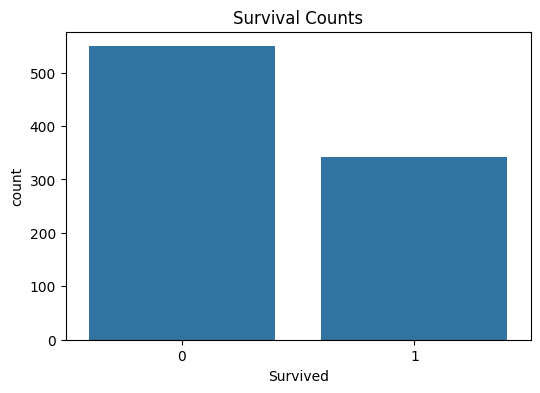

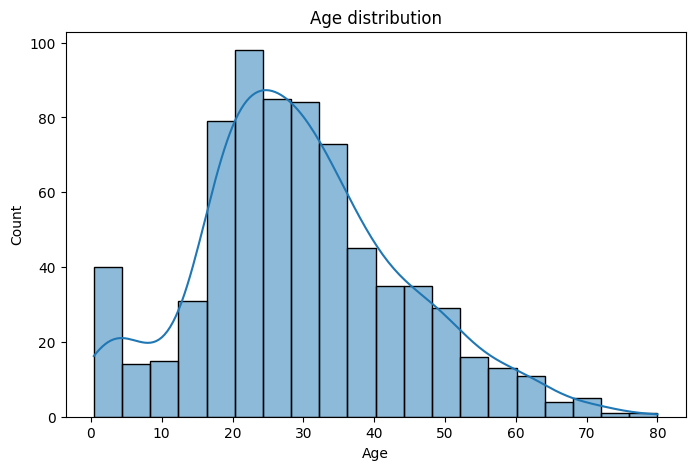

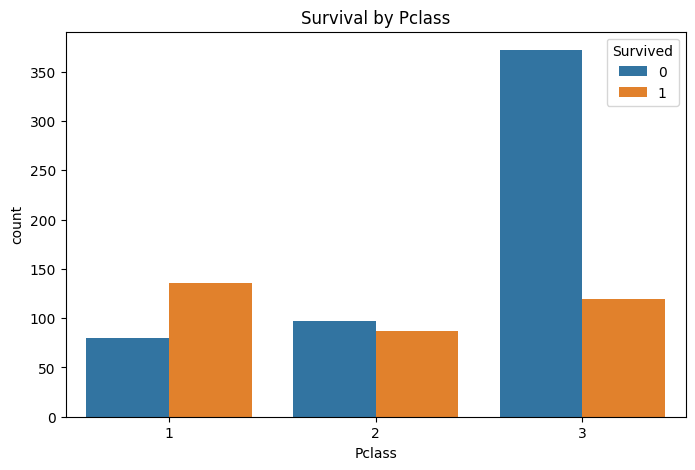

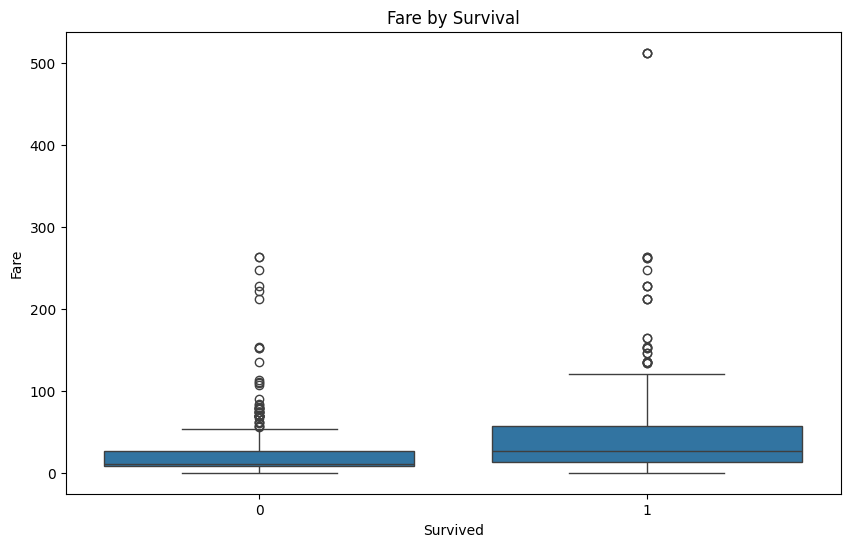

In [5]:
# Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=df)
plt.title('Survival Counts')


plt.figure(figsize=(8,5))
sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Age distribution')


plt.figure(figsize=(8,5))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Pclass')


plt.figure(figsize=(10,6))
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Fare by Survival')

4. Feature Engineering & Preprocessing Pipeline

In [7]:
# Feature engineering
import re


def extract_title(name):
  m = re.search(r",\s*([^.]*)\.", name)
  return m.group(1).strip() if m else 'None'

data = df.copy()
data['Title'] = data['Name'].apply(extract_title)
title_map = {
'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master'
}

data['Title'] = data['Title'].map(lambda t: t if t in title_map else 'Rare')

data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

data['IsAlone'] = (data['FamilySize'] == 1).astype(int)


# Drop columns
data = data.drop(columns=['PassengerId','Ticket','Cabin','Name'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,2,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,1,1
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0
4,0,3,male,35.0,0,0,8.0500,S,Mr,1,1


In [8]:
# preprocessing pipeline
numeric_features = ['Age','Fare','FamilySize']
numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])


categorical_features = ['Pclass','Sex','Embarked','Title','IsAlone']
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, numeric_features),
('cat', categorical_transformer, categorical_features)
])

5. Prepare train/test sets

In [9]:
# Split
X = data.drop(columns='Survived')
y = data['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
stratify=y, random_state=42)
print(X_train.shape, X_test.shape)

(712, 10) (179, 10)


6. Model training helper & baseline models

In [11]:
# training and evaluating the model
from sklearn.pipeline import make_pipeline


def train_and_eval(model_pipeline, X_train, y_train, X_test, y_test, cv=5):
  cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv, scoring='f1')
  model_pipeline.fit(X_train, y_train)
  preds = model_pipeline.predict(X_test)
  probas = None
  if hasattr(model_pipeline, 'predict_proba'):
    try:
      probas = model_pipeline.predict_proba(X_test)[:,1]
    except Exception:
      pass
  elif hasattr(model_pipeline, 'decision_function'):
    try:
      probas = model_pipeline.decision_function(X_test)
    except Exception:
      pass

  results = {
    'cv_f1_mean': np.mean(cv_scores),
    'accuracy': accuracy_score(y_test, preds),
    'precision': precision_score(y_test, preds),
    'recall': recall_score(y_test, preds),
    'f1': f1_score(y_test, preds),
    'confusion_matrix': confusion_matrix(y_test, preds),
    'probas': probas,
    'preds': preds
  }
  return results

In [13]:
# baseline model pipelines
models = {
'LogisticRegression': Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))]),
'DecisionTree': Pipeline(steps=[('pre', preprocessor), ('clf', DecisionTreeClassifier(random_state=42))]),
'RandomForest': Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))]),
'SVM': Pipeline(steps=[('pre', preprocessor), ('clf', SVC(probability=True))]),
'KNN': Pipeline(steps=[('pre', preprocessor), ('clf', KNeighborsClassifier())])
}


results_summary = {}
for name, pipeline in models.items():
  print('Training', name)
res = train_and_eval(pipeline, X_train, y_train, X_test, y_test, cv=5)
results_summary[name] = res
print(name, 'F1:', res['f1'], 'Accuracy:', res['accuracy'])


# comparison table
summary_rows = []
for name, res in results_summary.items():
  summary_rows.append([name, res['cv_f1_mean'], res['accuracy'], res['precision'], res['recall'], res['f1']])


summary_df = pd.DataFrame(summary_rows, columns=['Model','CV_F1','Accuracy','Precision','Recall','F1'])
summary_df.sort_values('F1', ascending=False)

Training LogisticRegression
Training DecisionTree
Training RandomForest
Training SVM
Training KNN
KNN F1: 0.7424242424242424 Accuracy: 0.8100558659217877


,Model,CV_F1,Accuracy,Precision,Recall,F1
0,KNN,0.730493,0.810056,0.777778,0.710145,0.742424


7. Hyperparameter Tuning (GridSearchCV)

In [14]:
# Grid search for RandomForest
param_grid_rf = {
'clf__n_estimators':[50,100,200],
'clf__max_depth':[None,5,10],
'clf__min_samples_split':[2,5]
}
rf_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))])
rf_gs = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
rf_gs.fit(X_train, y_train)
print('Best RF params:', rf_gs.best_params_)
rf_best = rf_gs.best_estimator_
rf_res = train_and_eval(rf_best, X_train, y_train, X_test, y_test)
rf_res

Best RF params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}


{'cv_f1_mean': np.float64(0.751282259338562),
 'accuracy': 0.8044692737430168,
 'precision': 0.7833333333333333,
 'recall': 0.6811594202898551,
 'f1': 0.7286821705426356,
 'confusion_matrix': array([[97, 13],
        [22, 47]]),
 'probas': array([0.0872197 , 0.08255356, 0.18689438, 0.02983839, 0.80227778,
        0.3445655 , 0.73144689, 0.47552808, 0.60087164, 0.14243878,
        0.18412066, 0.07361097, 0.37941201, 0.1924689 , 0.31412088,
        0.07655984, 0.0069697 , 0.0815771 , 0.06124947, 0.87311355,
        0.0815771 , 0.92039316, 0.19156739, 0.48435555, 0.14895834,
        0.97892857, 0.18412066, 0.41651738, 0.10165781, 0.16676706,
        0.12994617, 0.98714286, 0.78233333, 0.0588828 , 0.59528571,
        0.78919048, 0.561     , 0.1999062 , 0.18412066, 0.93333333,
        0.62009524, 0.9137381 , 0.18653137, 0.96518519, 0.80061355,
        0.09009135, 0.0645408 , 0.33337363, 0.8955    , 0.85016667,
        0.97      , 0.28607868, 0.87704244, 0.04311271, 0.39597492,
        0.092

In [15]:
# Grid search for SVM
param_grid_svc = {
'clf__C':[0.1,1,10],
'clf__kernel':['rbf','linear'],
'clf__gamma':['scale','auto']
}
svc_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', SVC(probability=True))])
svc_gs = GridSearchCV(svc_pipeline, param_grid_svc, cv=5, scoring='f1', n_jobs=-1)
svc_gs.fit(X_train, y_train)
print('Best SVC params:', svc_gs.best_params_)
svc_best = svc_gs.best_estimator_
svc_res = train_and_eval(svc_best, X_train, y_train, X_test, y_test)
svc_res

Best SVC params: {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}


{'cv_f1_mean': np.float64(0.7652617835421681),
 'accuracy': 0.8379888268156425,
 'precision': 0.8225806451612904,
 'recall': 0.7391304347826086,
 'f1': 0.7786259541984732,
 'confusion_matrix': array([[99, 11],
        [18, 51]]),
 'probas': array([0.09753483, 0.10506958, 0.1634493 , 0.08070305, 0.76869218,
        0.68715737, 0.81654775, 0.21676527, 0.17562394, 0.14327045,
        0.15504245, 0.12108384, 0.75073557, 0.15819861, 0.31012103,
        0.15638362, 0.247223  , 0.14981621, 0.15763613, 0.82089492,
        0.14981621, 0.81453781, 0.14984733, 0.59102853, 0.14979448,
        0.8339161 , 0.15504245, 0.15176128, 0.15451952, 0.15519386,
        0.15058104, 0.79732296, 0.45529367, 0.1504583 , 0.5933871 ,
        0.65063576, 0.59685667, 0.08282281, 0.15504245, 0.82127965,
        0.24159214, 0.84006776, 0.14412742, 0.83955561, 0.82778139,
        0.15290834, 0.14993219, 0.65622728, 0.73556422, 0.86611488,
        0.79998906, 0.74829065, 0.82541172, 0.14330001, 0.78771229,
        0.15

8. Evaluation: Confusion Matrix, ROC, AUC

Text(33.22222222222222, 0.5, 'Actual')

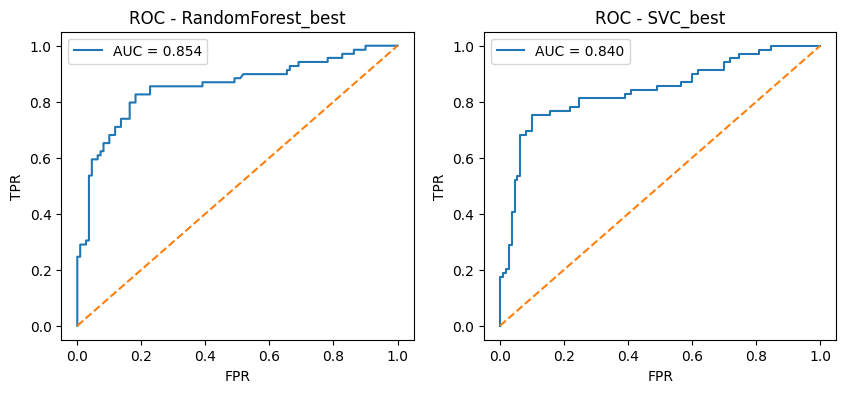

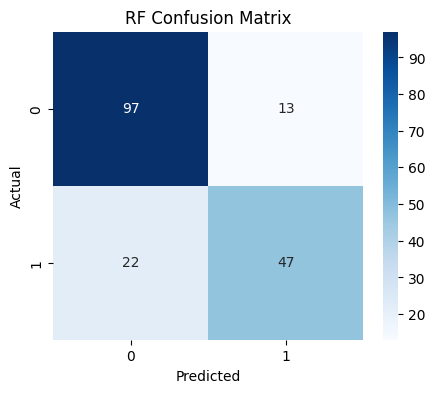

In [17]:
# Confusion matrix and ROC for best models
from sklearn.metrics import RocCurveDisplay


best_candidates = {'RandomForest_best': rf_best, 'SVC_best': svc_best}


plt.figure(figsize=(10,4))
for i, (name, pipe) in enumerate(best_candidates.items(),1):
  plt.subplot(1,2,i)
  proba = pipe.predict_proba(X_test)[:,1]
  fpr, tpr, _ = roc_curve(y_test, proba)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
  plt.plot([0,1],[0,1],'--')
  plt.title(f'ROC - {name}')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend()


# Confusion matrix for RF
import seaborn as sns
cm = confusion_matrix(y_test, rf_best.predict(X_test))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

9. Feature Importance

Text(0.5, 1.0, 'Top feature importances (RF)')

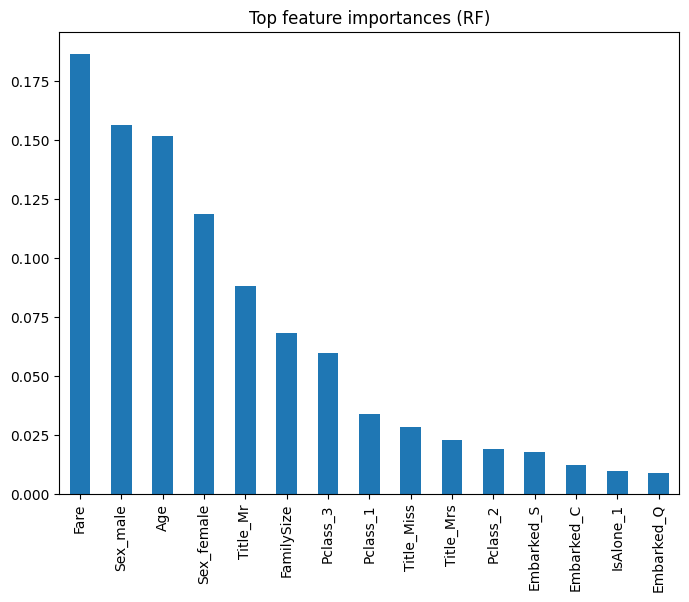

In [18]:
# extract column names after preprocessing
pipe = rf_best

ohe = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
cat_cols = ohe.get_feature_names_out(['Pclass','Sex','Embarked','Title','IsAlone'])
all_features = np.concatenate([numeric_features, cat_cols])


importances = pipe.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
feat_imp.head(15)


plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='bar')
plt.title('Top feature importances (RF)')

10. Final Comparison Table & Conclusions

In [19]:
# Collect final metrics into a table
final_rows = []
for name, item in [('RF_best', rf_res), ('SVC_best', svc_res)] + list(results_summary.items()):
  if isinstance(name, str) and name in ['RF_best','SVC_best']:
    row_name = name
    res = item
  else:
    row_name = name
    res = item
    final_rows.append([row_name, res['accuracy'], res['precision'], res['recall'], res['f1']])


final_df = pd.DataFrame(final_rows, columns=['Model','Accuracy','Precision','Recall','F1'])
final_df.sort_values('F1', ascending=False)

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.810056,0.777778,0.710145,0.742424
